# Final AI/ML Project Model Exploration

This script utilizes Masshchusetts school-level data to investigate if education policy and school-level characteristics in Massachusetts can predict student outcomes, which can inform discussions on policy and funding. 

## Data Cleaning

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import warnings
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score,
    recall_score, precision_score, precision_recall_curve,
    auc, f1_score, make_scorer
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TunedThresholdClassifierCV
import statsmodels.api as sm

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report
import seaborn as sns

In [2]:
all_results = []

data = pd.read_csv("/Users/kaylenamann/Downloads/BC Grad/2025Fall_ADAN7430/assignments/Final_Project/Raw Data/EducationData.csv")

def clean_data_exploration(df, cutoff=None, training_columns=None, is_training=True):
    
    df = df.copy()
    
    df["title_i_binary"] = df["title_i_status"].apply(
        lambda x: 1 if "swp" in str(x).lower() or "tas" in str(x).lower() else 0
    )
    
    df["school_level"] = (
        df["school_level"]
        .astype(str)
        .str.strip()
        .str.title()
    )
    
    school_level_map = {
        "Prekindergarten": "Elementary",
        "Primary": "Elementary",
        "Elementary": "Elementary",
        "Middle": "Middle",
        "Secondary": "High",
        "High": "High"
    }
    df["school_level_clean"] = df["school_level"].map(school_level_map).fillna("Other")
    
    df["school_type"] = df["school_type"].astype(str).str.strip()
    school_type_map = {
        "Special education school": "Specialized",
        "Vocational school": "Specialized",
        "Regular school": "Regular school"
    }
    df["school_type_clean"] = df["school_type"].map(school_type_map).fillna("Other")
    
    df["charter"] = df["charter"].astype(str).str.strip().str.title()
    df["charter"] = df["charter"].map({
        "Yes": "Yes",
        "No": "No",
        "Charter": "Yes",
        "Not Charter": "No",
        "1": "Yes",
        "0": "No",
        "True": "Yes",
        "False": "No"
    }).fillna("No")
    
    df["meps_poverty_pct"] = pd.to_numeric(df["meps_poverty_pct"], errors="coerce")
    
    if is_training:
        df["math_test_pct_prof_midpt"] = pd.to_numeric(
            df["math_test_pct_prof_midpt"], errors="coerce"
        )
        df = df.dropna(subset=["math_test_pct_prof_midpt"]) 
    
        if cutoff is None:
            cutoff = df["math_test_pct_prof_midpt"].quantile(0.25)
    
        df["y"] = (df["math_test_pct_prof_midpt"] <= cutoff).astype(int)
    
    predictors = [
        "enrollment",
        "direct_certification",  
        "meps_poverty_pct",
        "meps_mod_poverty_pct", 
        "school_level_clean",
        "school_type_clean",  
        "charter",
        "title_i_binary"
    ]
    
    X = df[predictors].copy()
    
    continuous_cols = [
        "enrollment",
        "direct_certification",
        "meps_poverty_pct",
        "meps_mod_poverty_pct"
    ]
    
    X[continuous_cols] = X[continuous_cols].fillna(X[continuous_cols].mean())
 
    X = pd.get_dummies(X, drop_first=True)
    
    if not is_training and training_columns is not None:
        X = X.reindex(columns=training_columns, fill_value=0)

    if is_training:
        y = df["y"]
        return X, y, cutoff, X.columns.tolist(), continuous_cols
    else:
        return X
        
years = sorted(data["year"].unique())
train_years = years[:-1]  
test_year = years[-1]     
train_data = data[data["year"].isin(train_years)].copy()
test_data = data[data["year"] == test_year].copy()

X_train, y_train, cutoff, training_columns, continuous_features = clean_data_exploration(
    train_data, 
    cutoff=None,
    training_columns=None,
    is_training=True
)

## Defining Outcome
To classify schools as low-proficiency, we are computing below 25% (1) versus above 25% (0) 

In [3]:
X_test = clean_data_exploration(
    test_data,
    cutoff=cutoff,
    training_columns=training_columns,
    is_training=False
)

test_data["math_test_pct_prof_midpt"] = pd.to_numeric(
    test_data["math_test_pct_prof_midpt"], errors="coerce"
)

y_test = (test_data.loc[X_test.index, "math_test_pct_prof_midpt"] <= cutoff).astype(int)

print("Class balance (train):", y_train.value_counts(normalize=True).round(3))
print("Class balance (test):", y_test.value_counts(normalize=True).round(3))
print(f"Training samples: {len(y_train)}, Test samples: {len(y_test)}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}") 

Class balance (train): y
0    0.729
1    0.271
Name: proportion, dtype: float64
Class balance (test): math_test_pct_prof_midpt
0    0.747
1    0.253
Name: proportion, dtype: float64
Training samples: 3334, Test samples: 1872
X_test shape: (1872, 11), y_test shape: (1872,)


## Box-tidwell Test for non-linearity

In [4]:
# Box-Tidwell Test for linearity
continuous_features = ['enrollment', 'direct_certification', 'meps_poverty_pct', 'meps_mod_poverty_pct']

X_bt = X_train[continuous_features].copy()
eps = 1e-5
for var in continuous_features:
    X_bt[f"{var}_logint"] = X_bt[var] * np.log(X_bt[var] + eps)

X_bt = X_bt.replace([np.inf, -np.inf], np.nan).dropna()

train_data["math_test_pct_prof_midpt"] = pd.to_numeric(
    train_data["math_test_pct_prof_midpt"], errors="coerce"
)

y_bt = (train_data.loc[X_bt.index, "math_test_pct_prof_midpt"] <= float(cutoff)).astype(int)

X_bt_sm = sm.add_constant(X_bt)
bt_model = sm.GLM(
    y_bt,
    X_bt_sm,
    family=sm.families.Binomial()
)
bt_results = bt_model.fit()
print(bt_results.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     math_test_pct_prof_midpt   No. Observations:                 3334
Model:                                  GLM   Df Residuals:                     3325
Model Family:                      Binomial   Df Model:                            8
Link Function:                        Logit   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -1056.0
Date:                      Fri, 19 Dec 2025   Deviance:                       2112.1
Time:                              11:08:00   Pearson chi2:                 2.61e+03
No. Iterations:                           8   Pseudo R-squ. (CS):             0.4145
Covariance Type:                  nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

None of the features are showing non-linearity with the logit

In [5]:
#Creating a function to evaluate models 
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    
    print("\n" + "="*80)
    print(f"{name}")
    print("="*80)
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_prob):.3f}")
    print(f"PR AUC:    {pr_auc:.3f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

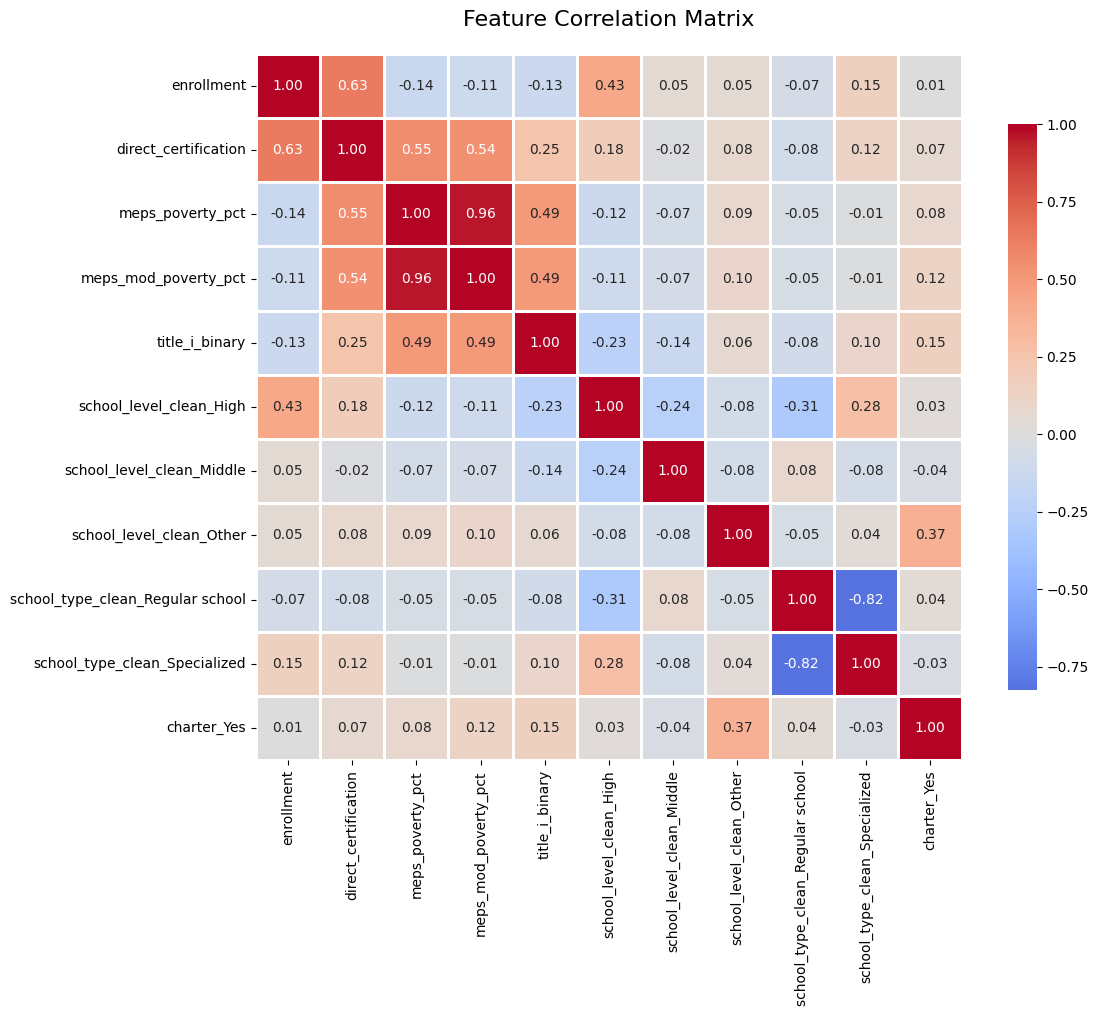

In [6]:
# Calculate correlation matrix
corr_matrix = X_train.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt='.2f',   
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## Base Logistic Model

In [7]:
base_logit = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    random_state=42
)
base_logit.fit(X_train, y_train)
evaluate_model("Baseline Logistic Regression", base_logit, X_test, y_test)


Baseline Logistic Regression
Accuracy:  0.834
Recall:    0.785
Precision: 0.641
F1 Score:  0.706
ROC AUC:   0.882
PR AUC:    0.733

Confusion Matrix:
[[1190  208]
 [ 102  372]]


## Ridge logistic

In [17]:
ridge_logit = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 20), 
    cv=5,
    penalty="l2",
    solver="lbfgs",
    class_weight="balanced",
    scoring="f1",
    max_iter=5000,
    random_state=33
)

ridge_logit.fit(X_train, y_train)
evaluate_model("Ridge Logistic Regression", ridge_logit, X_test, y_test)


Ridge Logistic Regression
Accuracy:  0.840
Recall:    0.802
Precision: 0.648
F1 Score:  0.717
ROC AUC:   0.892
PR AUC:    0.741

Confusion Matrix:
[[1192  206]
 [  94  380]]


## Decision Tree

In [9]:
dtree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)
dtree.fit(X_train, y_train)
evaluate_model("Decision Tree", dtree, X_test, y_test)


Decision Tree
Accuracy:  0.795
Recall:    0.819
Precision: 0.566
F1 Score:  0.669
ROC AUC:   0.890
PR AUC:    0.715

Confusion Matrix:
[[1100  298]
 [  86  388]]


## Clustering

In [10]:
knn = KNeighborsClassifier(n_neighbors=11)
best_knn_model = TunedThresholdClassifierCV(
    knn,
    scoring=make_scorer(f1_score),
    cv=5,
    random_state=42
)
best_knn_model.fit(X_train, y_train)
evaluate_model("KNN (Threshold Tuned)", best_knn_model, X_test, y_test)


KNN (Threshold Tuned)
Accuracy:  0.803
Recall:    0.823
Precision: 0.578
F1 Score:  0.679
ROC AUC:   0.883
PR AUC:    0.695

Confusion Matrix:
[[1113  285]
 [  84  390]]


In [11]:
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    return {
        "auc": roc_auc_score(y_test, y_prob),
        "f1": f1_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred)
    }
baseline_metrics = get_metrics(base_logit, X_test, y_test)
ridge_metrics    = get_metrics(ridge_logit, X_test, y_test)
tree_metrics     = get_metrics(dtree, X_test, y_test)
knn_metrics      = get_metrics(best_knn_model, X_test, y_test)

fold_results = {
    "test_year": test_year,
    "baseline_auc": baseline_metrics["auc"],
    "ridge_auc": ridge_metrics["auc"],
    "tree_auc": tree_metrics["auc"],
    "knn_auc": knn_metrics["auc"],
    "baseline_f1": baseline_metrics["f1"],
    "ridge_f1": ridge_metrics["f1"],
    "tree_f1": tree_metrics["f1"],
    "knn_f1": knn_metrics["f1"]
}

all_results.append(fold_results)
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("SUMMARY OF ALL RESULTS")
print("="*80)
print("\nROC AUC by Year:")
print(results_df[["test_year", "baseline_auc", "ridge_auc", "tree_auc", "knn_auc"]])
print("\nF1 Score by Year:")
print(results_df[["test_year", "baseline_f1", "ridge_f1", "tree_f1", "knn_f1"]])
print("\nAverage Performance:")
print(results_df[["baseline_auc", "ridge_auc", "tree_auc", "knn_auc"]].mean())
print("\nResults DataFrame:")
print(results_df)


SUMMARY OF ALL RESULTS

ROC AUC by Year:
   test_year  baseline_auc  ridge_auc  tree_auc   knn_auc
0       2018      0.882121   0.891983  0.889522  0.882673

F1 Score by Year:
   test_year  baseline_f1  ridge_f1   tree_f1    knn_f1
0       2018     0.705882  0.716981  0.668966  0.678851

Average Performance:
baseline_auc    0.882121
ridge_auc       0.891983
tree_auc        0.889522
knn_auc         0.882673
dtype: float64

Results DataFrame:
   test_year  baseline_auc  ridge_auc  tree_auc   knn_auc  baseline_f1  \
0       2018      0.882121   0.891983  0.889522  0.882673     0.705882   

   ridge_f1   tree_f1    knn_f1  
0  0.716981  0.668966  0.678851  


## Testing out interactions and non-linear terms

In [12]:
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()

X_train_aug["poverty_sq"] = X_train_aug["meps_poverty_pct"] ** 2
X_test_aug["poverty_sq"] = X_test_aug["meps_poverty_pct"] ** 2

for col in X_train_aug.columns:
    if col.startswith("school_level_clean_"):
        X_train_aug[f"enroll_{col}"] = X_train_aug["meps_poverty_pct"] * X_train_aug[col]
        X_test_aug[f"enroll_{col}"] = X_test_aug["meps_poverty_pct"] * X_test_aug.get(col, 0)

aug_ridge_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("ridge", LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 20), 
    cv=5,
    penalty="l2",
    solver="lbfgs",
    class_weight="balanced",
    scoring="f1",
    max_iter=5000,
    random_state=33
    ))
])

aug_ridge_pipe.fit(X_train_aug, y_train)
y_pred_aug = aug_ridge_pipe.predict(X_test_aug)
y_prob_aug = aug_ridge_pipe.predict_proba(X_test_aug)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob_aug)
pr_auc = auc(recall, precision)

print("\n" + "="*80)
print("Augmented Ridge Logistic Regression (Polynomial + Interactions)")
print("="*80)
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob_aug):.3f}")
print(f"PR AUC:    {pr_auc:.3f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_aug):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_aug):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_aug):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_aug):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_aug))

print(f"\nBest regularization strength (C): {aug_ridge_pipe.named_steps['ridge'].C_[0]:.4f}")


Augmented Ridge Logistic Regression (Polynomial + Interactions)
ROC AUC:   0.881
PR AUC:    0.738
Accuracy:  0.825
Recall:    0.783
Precision: 0.622
F1 Score:  0.693

Confusion Matrix:
[[1173  225]
 [ 103  371]]

Best regularization strength (C): 0.0886


In [21]:
#Final model precision/recall
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

y_pred_ridge = ridge_logit.predict(X_test)
y_prob_ridge = ridge_logit.predict_proba(X_test)[:, 1]  

print(classification_report(
    y_test, 
    y_pred_ridge, 
    target_names=['Not Struggling (0)', 'Struggling (1)'],
    digits=3
))

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": ridge_logit.coef_[0],
    "odds_ratio": np.exp(ridge_logit.coef_[0])
}).sort_values(by="odds_ratio", ascending=False)

coef_df

                    precision    recall  f1-score   support

Not Struggling (0)      0.927     0.853     0.888      1398
    Struggling (1)      0.648     0.802     0.717       474

          accuracy                          0.840      1872
         macro avg      0.788     0.827     0.803      1872
      weighted avg      0.856     0.840     0.845      1872



,feature,coefficient,odds_ratio
6,school_level_clean_Middle,0.591749,1.807147
2,meps_poverty_pct,0.320939,1.378422
7,school_level_clean_Other,0.276522,1.318536
8,school_type_clean_Regular school,0.110025,1.116306
4,title_i_binary,0.083542,1.087131
1,direct_certification,0.003504,1.003511
0,enrollment,-0.003133,0.996872
10,charter_Yes,-0.006960,0.993065
3,meps_mod_poverty_pct,-0.082163,0.921122
9,school_type_clean_Specialized,-0.085566,0.917992


In [22]:
cm = confusion_matrix(y_test, y_pred_ridge)
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives (TN):  {tn:4d} - Correctly identified non-struggling schools")
print(f"False Positives (FP): {fp:4d} - Incorrectly flagged as struggling")
print(f"False Negatives (FN): {fn:4d} - MISSED struggling schools")
print(f"True Positives (TP):  {tp:4d} - Correctly identified struggling schools")
print(f"\nTotal Test Schools: {len(y_test)}")
print(f"Actual Struggling:  {(fn + tp)} ({100*(fn+tp)/len(y_test):.1f}%)")
print(f"Actual Not Struggling: {(tn + fp)} ({100*(tn+fp)/len(y_test):.1f}%)")

True Negatives (TN):  1192 - Correctly identified non-struggling schools
False Positives (FP):  206 - Incorrectly flagged as struggling
False Negatives (FN):   94 - MISSED struggling schools
True Positives (TP):   380 - Correctly identified struggling schools

Total Test Schools: 1872
Actual Struggling:  474 (25.3%)
Actual Not Struggling: 1398 (74.7%)


In [23]:
print("3. PERFORMANCE METRICS INTERPRETATION")

specificity = tn / (tn + fp)
npv = tn / (tn + fn)  
fpr = fp / (fp + tn)  
fnr = fn / (fn + tp)  

print(f"\nModel correctly identifies:")
print(f"  • {recall_score(y_test, y_pred_ridge):.1%} of struggling schools (Recall/Sensitivity)")
print(f"  • {specificity:.1%} of non-struggling schools (Specificity)")

print(f"\nWhen model predicts a school is struggling:")
print(f"  • It's correct {precision_score(y_test, y_pred_ridge):.1%} of the time (Precision/PPV)")

print(f"\nWhen model predicts a school is NOT struggling:")
print(f"  • It's correct {npv:.1%} of the time (Negative Predictive Value)")

print(f"\nError Rates:")
print(f"  • False Positive Rate: {fpr:.1%} ({fp}/{fp+tn} non-struggling schools incorrectly flagged)")
print(f"  • False Negative Rate: {fnr:.1%} ({fn}/{fn+tp} struggling schools MISSED)")



3. PERFORMANCE METRICS INTERPRETATION

Model correctly identifies:
  • 80.2% of struggling schools (Recall/Sensitivity)
  • 85.3% of non-struggling schools (Specificity)

When model predicts a school is struggling:
  • It's correct 64.8% of the time (Precision/PPV)

When model predicts a school is NOT struggling:
  • It's correct 92.7% of the time (Negative Predictive Value)

Error Rates:
  • False Positive Rate: 14.7% (206/1398 non-struggling schools incorrectly flagged)
  • False Negative Rate: 19.8% (94/474 struggling schools MISSED)


In [24]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_logit.coef_[0],
    'Abs_Coefficient': np.abs(ridge_logit.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeatures that INCREASE odds of struggling (positive coefficients):")
print(coef_df[coef_df['Coefficient'] > 0].head(10).to_string(index=False))

print("\nFeatures that DECREASE odds of struggling (negative coefficients):")
print(coef_df[coef_df['Coefficient'] < 0].head(10).to_string(index=False))



Features that INCREASE odds of struggling (positive coefficients):
                         Feature  Coefficient  Abs_Coefficient
       school_level_clean_Middle     0.591749         0.591749
                meps_poverty_pct     0.320939         0.320939
        school_level_clean_Other     0.276522         0.276522
school_type_clean_Regular school     0.110025         0.110025
                  title_i_binary     0.083542         0.083542
            direct_certification     0.003504         0.003504

Features that DECREASE odds of struggling (negative coefficients):
                      Feature  Coefficient  Abs_Coefficient
      school_level_clean_High    -0.626386         0.626386
school_type_clean_Specialized    -0.085566         0.085566
         meps_mod_poverty_pct    -0.082163         0.082163
                  charter_Yes    -0.006960         0.006960
                   enrollment    -0.003133         0.003133


In [25]:
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"\nCurrent threshold: 0.5 (default)")
print(f"\nAlternative threshold performance:")
print(f"{'Threshold':<12} {'Recall':<10} {'Precision':<12} {'F1':<10} {'Accuracy':<10}")
print("-" * 54)

for thresh in thresholds_to_test:
    y_pred_thresh = (y_prob_ridge >= thresh).astype(int)
    rec = recall_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    acc = accuracy_score(y_test, y_pred_thresh)
    print(f"{thresh:<12.1f} {rec:<10.3f} {prec:<12.3f} {f1:<10.3f} {acc:<10.3f}")


Current threshold: 0.5 (default)

Alternative threshold performance:
Threshold    Recall     Precision    F1         Accuracy  
------------------------------------------------------
0.3          0.899      0.495        0.639      0.743     
0.4          0.863      0.563        0.681      0.795     
0.5          0.802      0.648        0.717      0.840     
0.6          0.736      0.684        0.709      0.847     
0.7          0.650      0.711        0.679      0.845     


In [26]:

# False Negatives (missed struggling schools)
fn_indices = np.where((y_test == 1) & (y_pred_ridge == 0))[0]
fn_probs = y_prob_ridge[fn_indices]

print(f"\nFalse Negatives (n={len(fn_indices)}):")
print(f"  These are struggling schools the model MISSED")
print(f"  Average predicted probability: {fn_probs.mean():.3f}")
print(f"  These schools were close to threshold: {np.sum((fn_probs >= 0.4) & (fn_probs < 0.5))} had prob between 0.4-0.5")

# False Positives (incorrectly flagged)
fp_indices = np.where((y_test == 0) & (y_pred_ridge == 1))[0]
fp_probs = y_prob_ridge[fp_indices]

print(f"\nFalse Positives (n={len(fp_indices)}):")
print(f"  These are non-struggling schools incorrectly flagged")
print(f"  Average predicted probability: {fp_probs.mean():.3f}")
print(f"  High confidence errors: {np.sum(fp_probs >= 0.7)} had prob ≥ 0.7")



False Negatives (n=94):
  These are struggling schools the model MISSED
  Average predicted probability: 0.285
  These schools were close to threshold: 29 had prob between 0.4-0.5

False Positives (n=206):
  These are non-struggling schools incorrectly flagged
  Average predicted probability: 0.751
  High confidence errors: 125 had prob ≥ 0.7


Text(0.5, 1.0, 'Confusion Matrix')

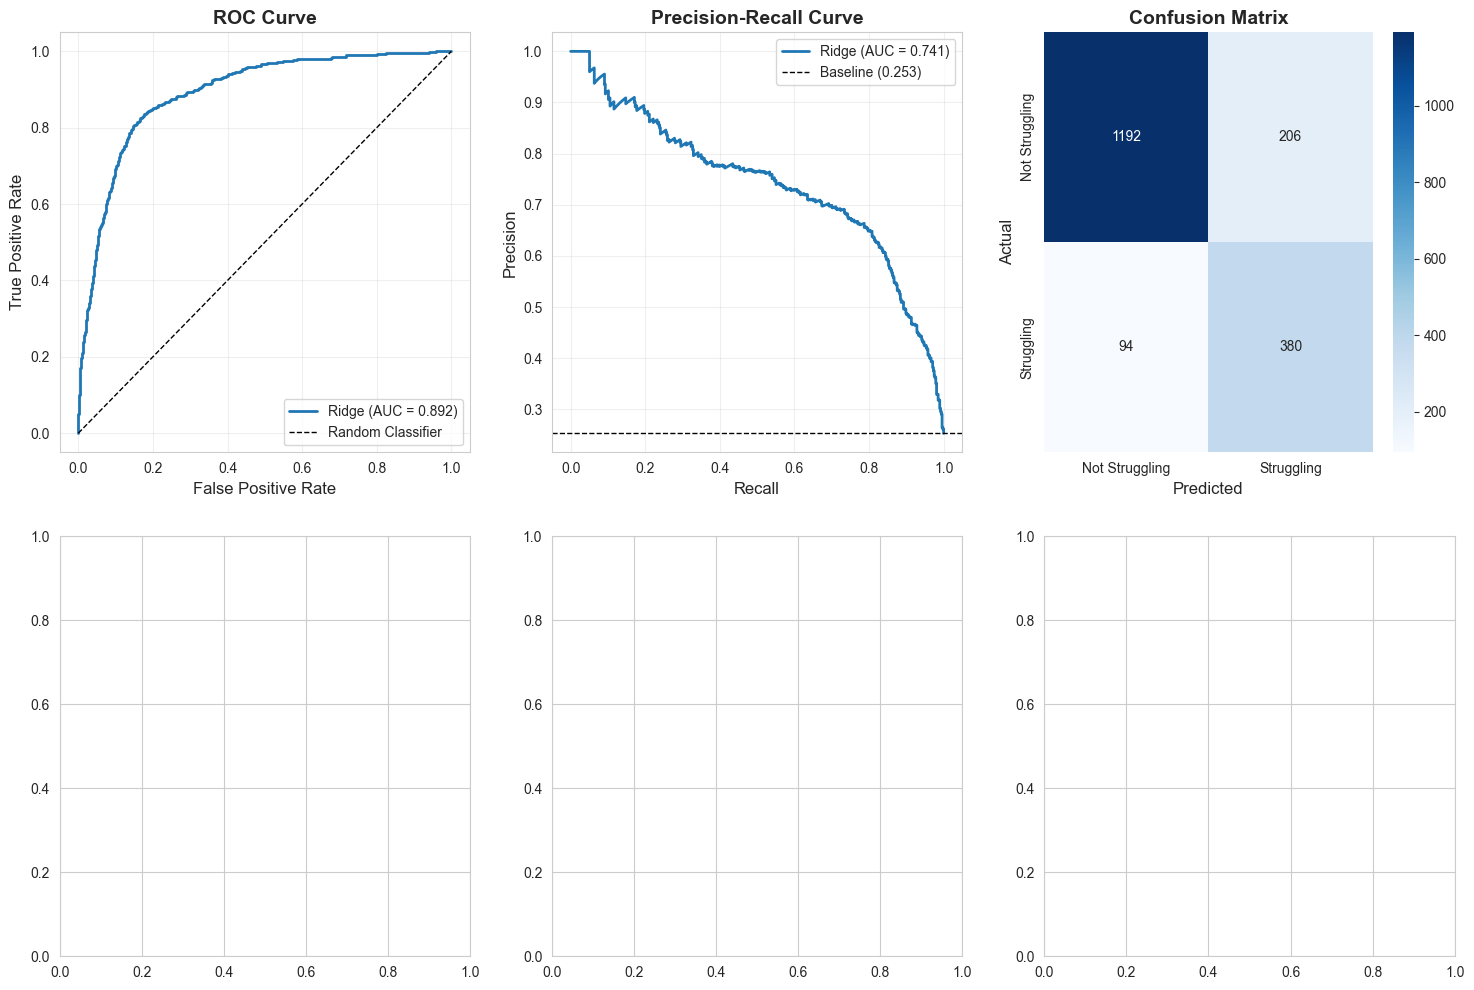

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 9.1 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_ridge)
axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'Ridge (AUC = {roc_auc_score(y_test, y_prob_ridge):.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 9.2 Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_ridge)
pr_auc_val = auc(recall, precision)
axes[0, 1].plot(recall, precision, linewidth=2, label=f'Ridge (AUC = {pr_auc_val:.3f})')
axes[0, 1].axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, label=f'Baseline ({y_test.mean():.3f})')
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 9.3 Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2],
            xticklabels=['Not Struggling', 'Struggling'],
            yticklabels=['Not Struggling', 'Struggling'])
axes[0, 2].set_ylabel('Actual', fontsize=12)
axes[0, 2].set_xlabel('Predicted', fontsize=12)
axes[0, 2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

In [29]:
high_conf_fp = test_data.iloc[fp_indices[fp_probs >= 0.7]]

print("High-confidence false positives:")
print(high_conf_fp[['enrollment', 'meps_poverty_pct', 
                     'direct_certification',
                     'math_test_pct_prof_midpt']].describe())

# Compare to true positives
high_conf_tp = test_data.iloc[np.where((y_test == 1) & (y_pred_ridge == 1))[0]]
print("\nTrue positives for comparison:")
print(high_conf_tp[['enrollment', 'meps_poverty_pct', 
                     'direct_certification',
                     'math_test_pct_prof_midpt']].describe())

High-confidence false positives:
        enrollment  meps_poverty_pct  direct_certification  \
count   125.000000        125.000000            124.000000   
mean    395.696000         21.150907            243.911290   
std     213.534851          3.213949            135.941344   
min       8.000000         14.921972             10.000000   
25%     253.000000         18.711288            150.000000   
50%     370.000000         21.214176            217.500000   
75%     517.000000         23.363865            322.000000   
max    1218.000000         29.667946            715.000000   

       math_test_pct_prof_midpt  
count                 94.000000  
mean                  47.824468  
std                    9.392489  
min                   38.000000  
25%                   42.000000  
50%                   46.500000  
75%                   50.750000  
max                   82.000000  

True positives for comparison:
        enrollment  meps_poverty_pct  direct_certification  \
count   